In [1]:
#!pip install https://github.com/msangnier/qreg/archive/master.zip
#!pip install cvxpy

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
from qreg import QRegressor

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from scipy.stats import norm
import cvxpy as cp

from VQR import VectorQuantileRegression

In [4]:
%matplotlib inline

In [5]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

# Engel's Data

In [6]:
X = pd.read_excel('Data/MVEngel.xls', 'X' ,header= None)
Y = pd.read_excel('Data/MVEngel.xls', 'Y' ,header= None).fillna(0)

X.columns = ['income']

Y.columns = ['food',
'clothing',
'housing',
'heating/lightening',
'tools',
'education',
'public safety',
'health',
'services'
]

Y_col = Y.columns

data = pd.concat([X,Y], axis =1)

In [7]:
x = data[data['income'] <2000]['income'].ravel()
y = data[data['income'] <2000]['food'].ravel()

In [8]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.33, random_state=42)

probs = np.linspace(0.1, 0.9, 5)
probs = np.round(probs,2)

In [9]:
probs


array([0.1, 0.3, 0.5, 0.7, 0.9])

# Classique

In [10]:
data_train = pd.DataFrame({'income': x_train, 'food': y_train})

In [11]:
mod = smf.quantreg('food ~ income', data_train)
tot_res = []
for q in probs:
    res = mod.fit(q=q)
    tot_res += [[res.params['Intercept'], res.params['income']]]

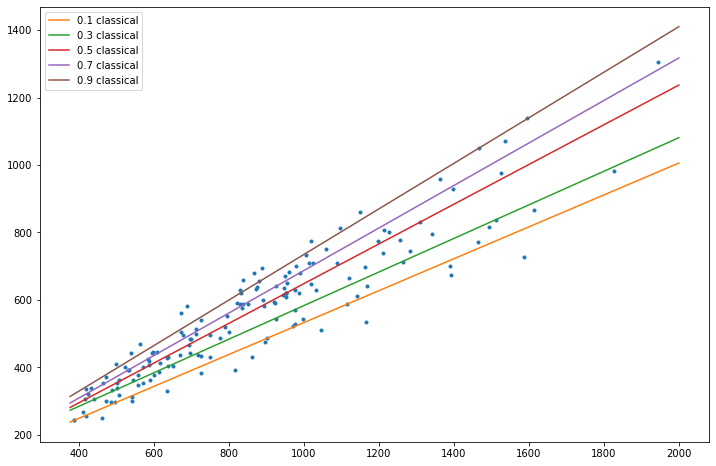

In [12]:
plt.plot(x_train, y_train, '.')

idx = x_test.argsort()

for i, q in enumerate(probs):
    plt.plot(x_test[idx], x_test[idx]*tot_res[i][1]+tot_res[i][0], '-', label=str(q)+" classical")
    
plt.legend()
plt.show()

# Kernel Singel

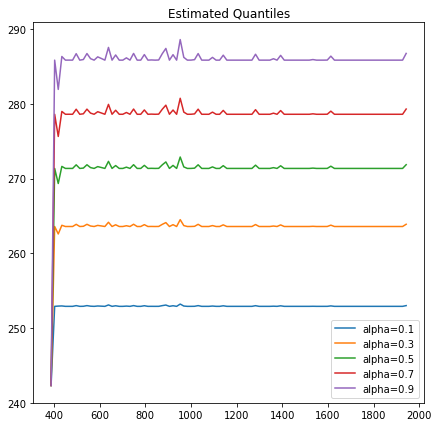

In [13]:
nsample = len(x_train)
X = x_train.copy()
y = y_train.copy()

gauss_kernel = lambda u,v,sigma=1: np.exp(-np.sum((u-v)**2)/sigma**2)
quantile_sol = lambda u,v,b: np.sum([v[i]*gauss_kernel(u,X[i]) for i in range(nsample)]) + b

sigma=0.1
lambd = 1

K = np.zeros((nsample,nsample))
for i in range(nsample):
    for j in range(nsample):
        K[i,j] = gauss_kernel(X[i],X[j],sigma)

alpha_l = probs

# Generate a random non-trivial quadratic program.
n = 3*nsample+1
m = 4*nsample

#np.random.seed(1)

P = np.zeros((n,n))
P[0:nsample,0:nsample] = K

G = np.zeros((m,n))
G[0:nsample,nsample:2*nsample] = -np.eye(nsample)
G[nsample:2*nsample,2*nsample:3*nsample] = -np.eye(nsample)
G[2*nsample:3*nsample,0:nsample] = -K
G[2*nsample:3*nsample,nsample:2*nsample] = -np.eye(nsample)
G[3*nsample:4*nsample,0:nsample] = K
G[3*nsample:4*nsample,2*nsample:3*nsample] = np.eye(nsample)
G[2*nsample:3*nsample,-1] = -1
G[3*nsample:4*nsample,-1] = 1

h = np.zeros(m)
h[2*nsample:3*nsample] = -y
h[3*nsample:4*nsample] = y

abscisse = np.linspace(min(X),max(X),100)
plt.figure(figsize=(7,7))

for alpha in alpha_l:

    q = np.zeros(n)
    q[nsample:2*nsample] = alpha
    q[2*nsample:3*nsample] = 1-alpha

    # Define and solve the CVXPY problem.
    x = cp.Variable(n)
    prob = cp.Problem(cp.Minimize(lambd*0.5*cp.quad_form(x, P) + q.T @ x),
                     [G @ x <= h])
    prob.solve()
    
    w_opt,b = x.value[:nsample],x.value[-1]
    
    t = [quantile_sol(xi,w_opt,b) for xi in abscisse]
    plt.plot(abscisse, t, label="alpha={}".format(np.round(alpha,2)))
    
#plt.plot(x_train, y_train, '.')
plt.title("Estimated Quantiles")
plt.legend()
plt.show()

# Kernel Simultanous qreg

In [14]:
# Define the quantile regressor

reg = QRegressor(C=1e2,  # Trade-off parameter
                 probs=probs,  # Quantile levels
                 gamma_out=1,  # Inner kernel parameter
                 eps=2,  # Epsilon-loss level
                 alg='sdca',  # Algorithm (can change to 'qp')
                 max_iter=1e4,  # Maximal number of iteration
                 active_set=True,  # Active set strategy
                 verbose=False)

# Fit on training data and predict on test data
reg.fit(x_train, y_train)
pred = reg.predict(x_test)


Objective value: -1643461.712969
Training time: 2.00s
#SV: 150
Score: -27.397475


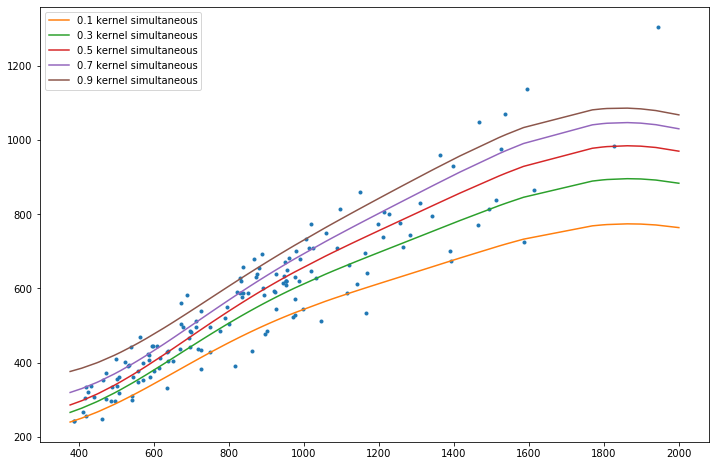

In [15]:
plt.plot(x_train, y_train, '.')

idx = x_test.argsort()

for i,q in enumerate(pred):
    plt.plot(x_test[idx], q[idx], '-', label=str(probs[i]) + " kernel simultaneous")
    
print("Objective value: %f" % reg.obj)
print("Training time: %0.2fs" % reg.time)
print("#SV: %d" % reg.num_sv())
print("Score: %f" % reg.score(x_test, y_test))

plt.legend()
plt.show()

# OT

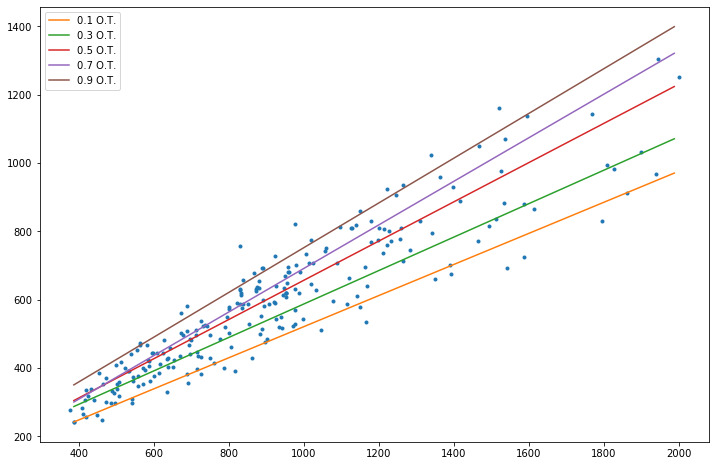

In [16]:
x = data[data['income'] <2000][['income']]
y = data[data['income'] <2000][['food']]

vqr = VectorQuantileRegression()
vqr.fit(x,y, step=0.01)

x_test = np.arange(int(np.min(X)), 2000, 100)
x_test = pd.DataFrame(x_test)

l_res = []
l_q = probs
for i in l_q:
    res = vqr.predict(x_test, u_quantile=[i], argument="X")['y_pred'].apply(lambda x : x[0][0]).ravel()
    l_res += [res]

plt.plot(x['income'].ravel(), y['food'].ravel(),'.')
for p in range(len(l_res)):
    plt.plot(x_test[0].ravel(),l_res[p], label=str(l_q[p]) + " O.T.")
plt.legend()